In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta


In [2]:
tickers = ["TSLA"]

In [3]:
end_date = datetime.today()
print(end_date)

2023-09-30 10:52:51.853399


In [4]:
start_date = end_date - timedelta(days = 4*365)
print(start_date)

2019-10-01 10:52:51.853399


In [5]:
close_df = pd.DataFrame()

In [6]:
for ticker in tickers:
    data = yf.download(ticker, start=start_date,end=end_date)
    close_df[ticker] = data['Close']

df= close_df
df.head()

[*********************100%%**********************]  1 of 1 completed


,TSLA
Date,
2019-10-01,16.312668
2019-10-02,16.208668
2019-10-03,15.535333
2019-10-04,15.428667
2019-10-07,15.848000


In [7]:
df = df.asfreq("b")
df = df.fillna(method="ffill")
df.isna().sum()

TSLA    0
dtype: int64

In [8]:
df.tail()

,TSLA
Date,
2023-09-25,246.990005
2023-09-26,244.119995
2023-09-27,240.500000
2023-09-28,246.380005
2023-09-29,250.220001


In [9]:
df['Returns'] = df.TSLA.pct_change()
df['lag_1'] = df.TSLA.shift(1)
df.isna().sum()

TSLA       0
Returns    1
lag_1      1
dtype: int64

In [10]:
corr = df.TSLA.corr(df.Returns)
corr

-0.04102495348800785

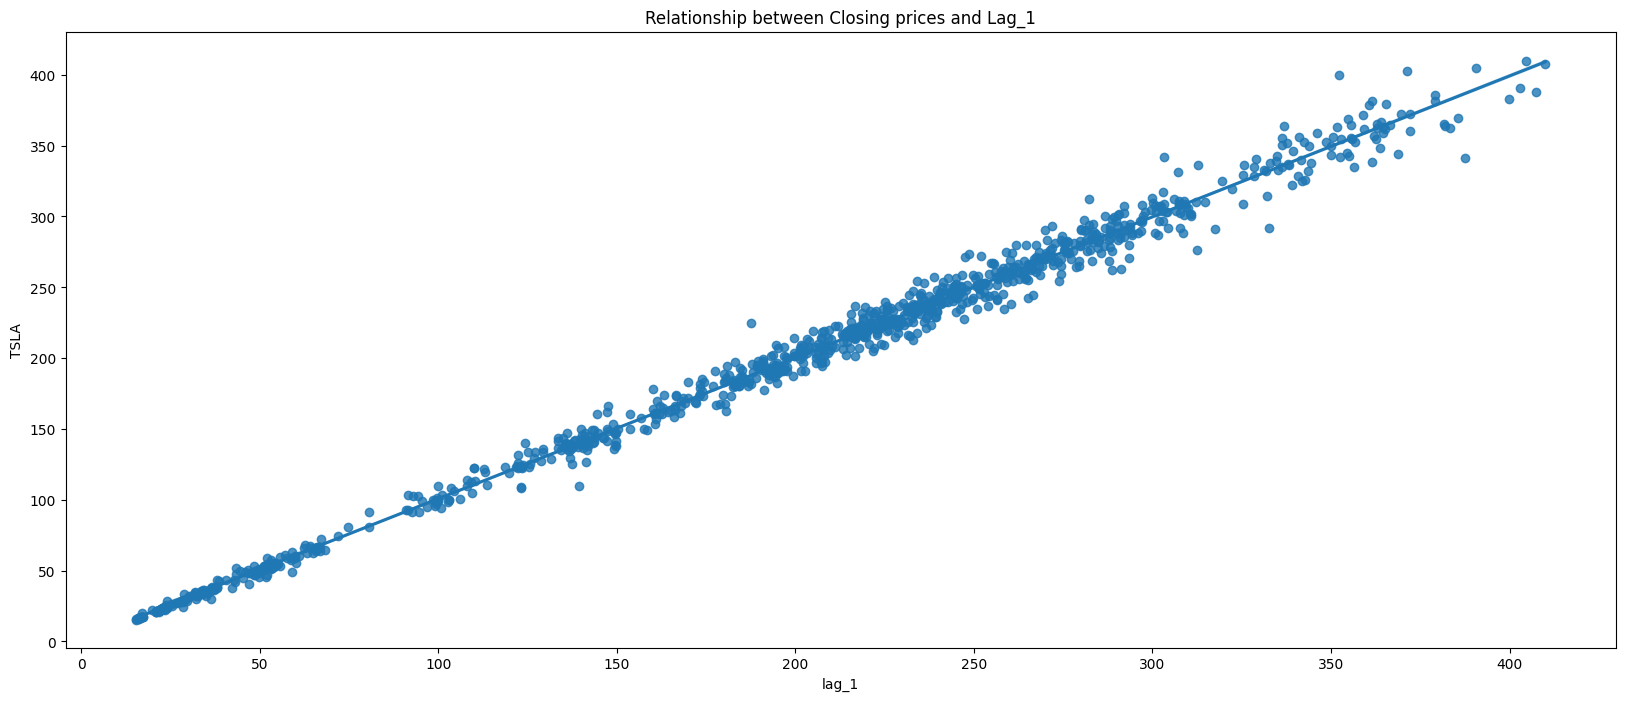

In [11]:
plt.figure(figsize=(20,8))
sns.regplot( x=df.lag_1,y=df.TSLA)
plt.title("Relationship between Closing prices and Lag_1")
plt.show()

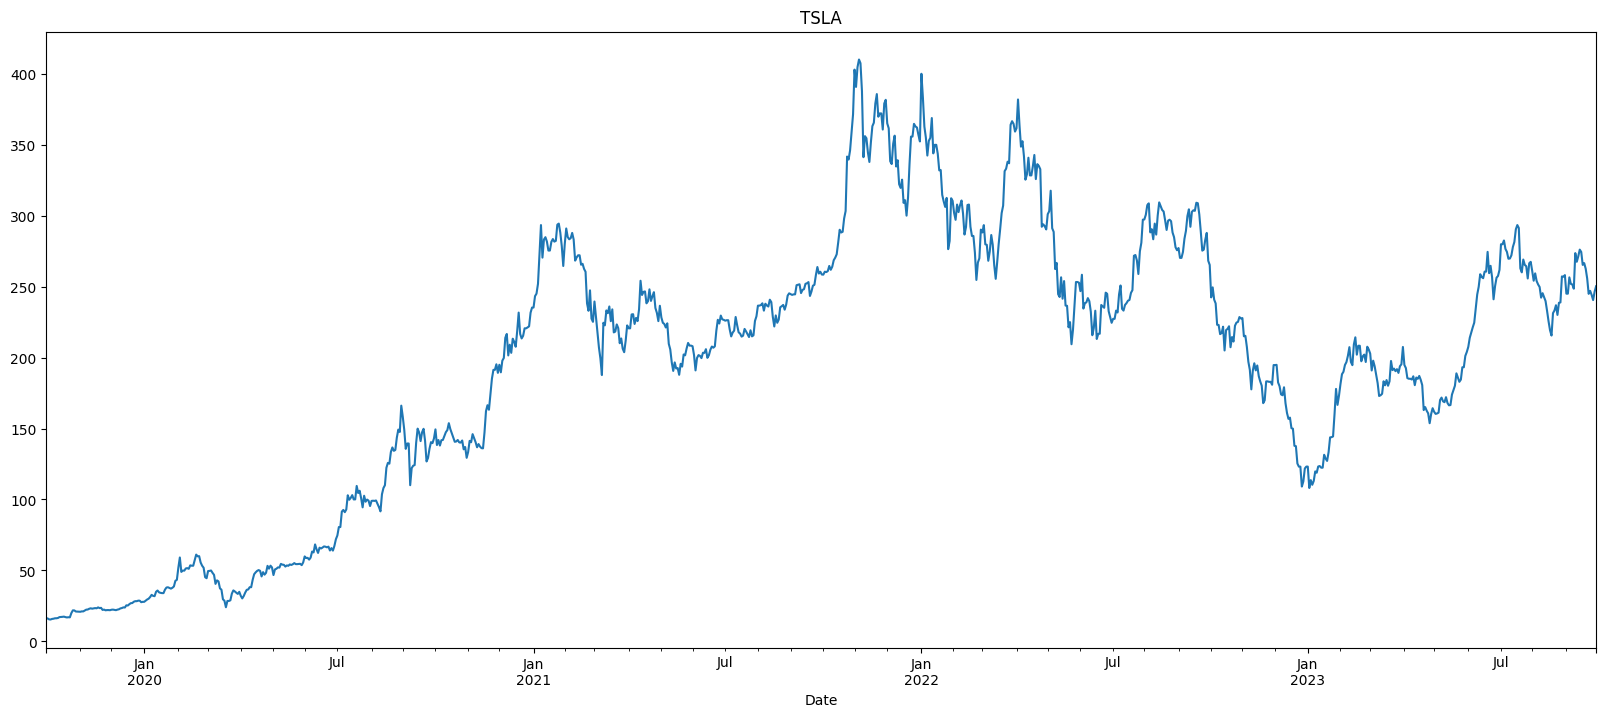

In [12]:
plt.figure(figsize=(20,8))
df.TSLA.plot()
plt.title("TSLA")
plt.show()

<Figure size 2000x1000 with 0 Axes>

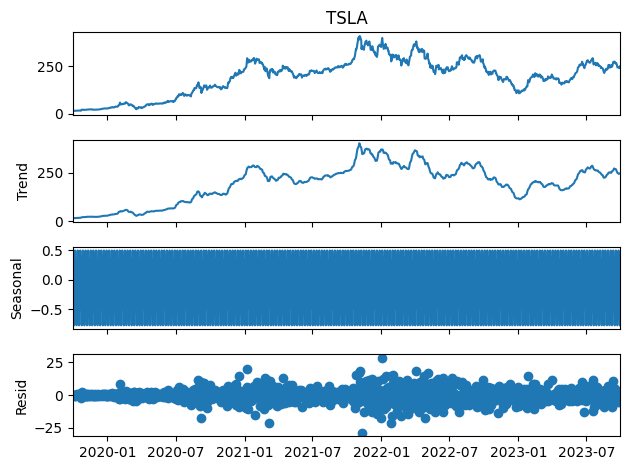

In [13]:
plt.figure(figsize=(20,10))
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['TSLA'], model='additive')
decomposition.plot()
plt.show()


In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['TSLA'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] <= 0.05:
    print("Reject the null hypothesis - Data is stationary")
else:
    print("Fail to reject the null hypothesis - Data is not stationary")


ADF Statistic: -2.0853904479615744
p-value: 0.2504296084745127
Fail to reject the null hypothesis - Data is not stationary


<Figure size 2000x1000 with 0 Axes>

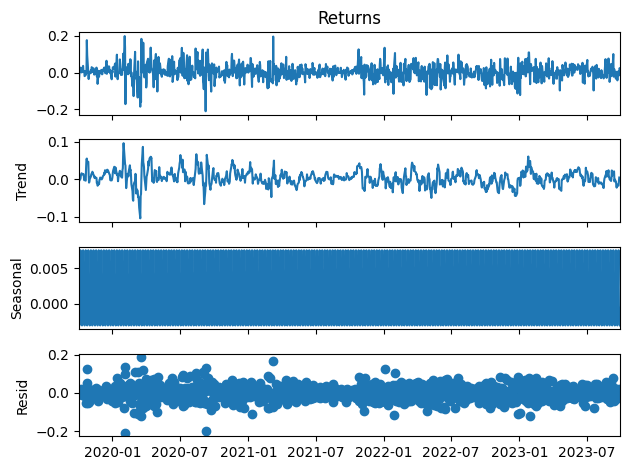

In [15]:
plt.figure(figsize=(20,10))
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.Returns[1:], model='additive')
decomposition.plot()
plt.show()


In [16]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Returns[1:])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] <= 0.05:
    print("Reject the null hypothesis - Data is stationary")
else:
    print("Fail to reject the null hypothesis - Data is not stationary")

ADF Statistic: -9.507840067473266
p-value: 3.310312214024427e-16
Reject the null hypothesis - Data is stationary


<Figure size 2000x800 with 0 Axes>

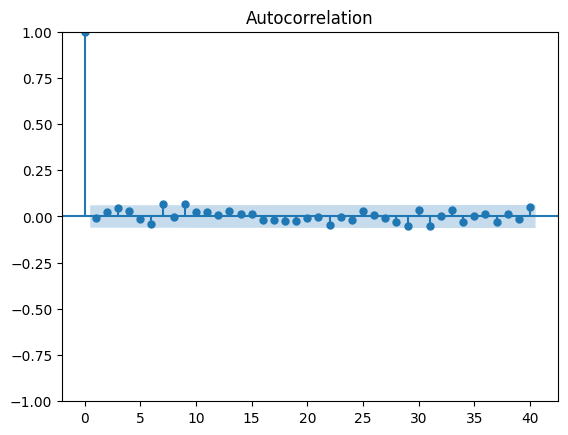

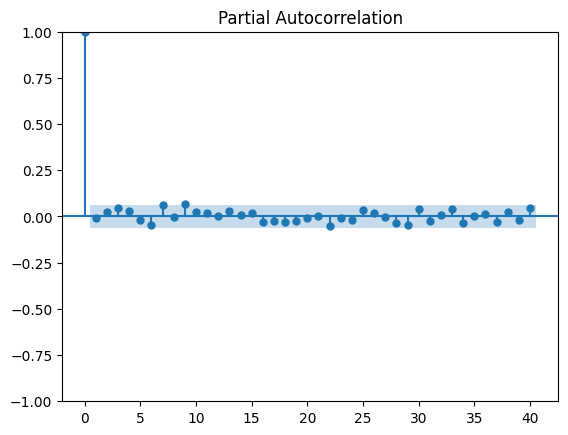

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(20,8))
# Plot ACF and PACF to estimate p and q
plot_acf(df.Returns[1:], lags=40)
plot_pacf(df.Returns[1:], lags=40)
plt.show()


In [18]:
import pmdarima as pm

# Fit an Auto-ARIMA model
auto_arima_model = pm.auto_arima(df['TSLA'], seasonal=True, stepwise=True, trace=True, suppress_warnings=True, error_action="ignore")

# Get the best-fitting ARIMA model's orders (p, d, q) and seasonal orders (P, D, Q, s)
best_p, best_d, best_q = auto_arima_model.order
best_P, best_D, best_Q, best_s = auto_arima_model.seasonal_order

print("Best ARIMA Orders:", (best_p, best_d, best_q))
print("Best Seasonal Orders:", (best_P, best_D, best_Q, best_s))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7353.472, Time=4.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7361.239, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7361.674, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7361.686, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7360.013, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7365.151, Time=2.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7365.664, Time=0.80 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7358.692, Time=3.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7358.777, Time=2.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7363.167, Time=1.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7366.099, Time=1.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7366.252, Time=1.62 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7360.692, Time=3.81 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7352.265, Time=1.72 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA model with selected orders (p, d, q)
p, d, q = (2, 1, 2)  # Replace with your selected values
model = ARIMA(df.TSLA.dropna(), order=(p, d, q))
results = model.fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TSLA   No. Observations:                 1044
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3671.133
Date:                Sat, 30 Sep 2023   AIC                           7352.265
Time:                        10:53:55   BIC                           7377.015
Sample:                    10-01-2019   HQIC                          7361.653
                         - 09-29-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7702      0.024     32.193      0.000       0.723       0.817
ar.L2         -0.9190      0.026    -35.959      0.000      -0.969      -0.869
ma.L1         -0.8093      0.017    -47.409      0.000      -0.843      -0.776
ma.L2          0.9620      0.017     56.386      0.000       0.929       0.995
sigma2        66.7750      1.702     39.224      0.000      63.438      70.112
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               750.55
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Forecast the next 'n' periods
n = 5  # Replace with the number of periods you want to forecast
forecast = results.forecast(steps=n)
# Print the forecasted values
print(f"forecasted closing prices are as follow: {forecast}")
      

forecasted closing prices are as follow: 2023-10-02    251.710113
2023-10-03    253.494658
2023-10-04    253.499657
2023-10-05    251.863496
2023-10-06    250.598761
Freq: B, Name: predicted_mean, dtype: float64


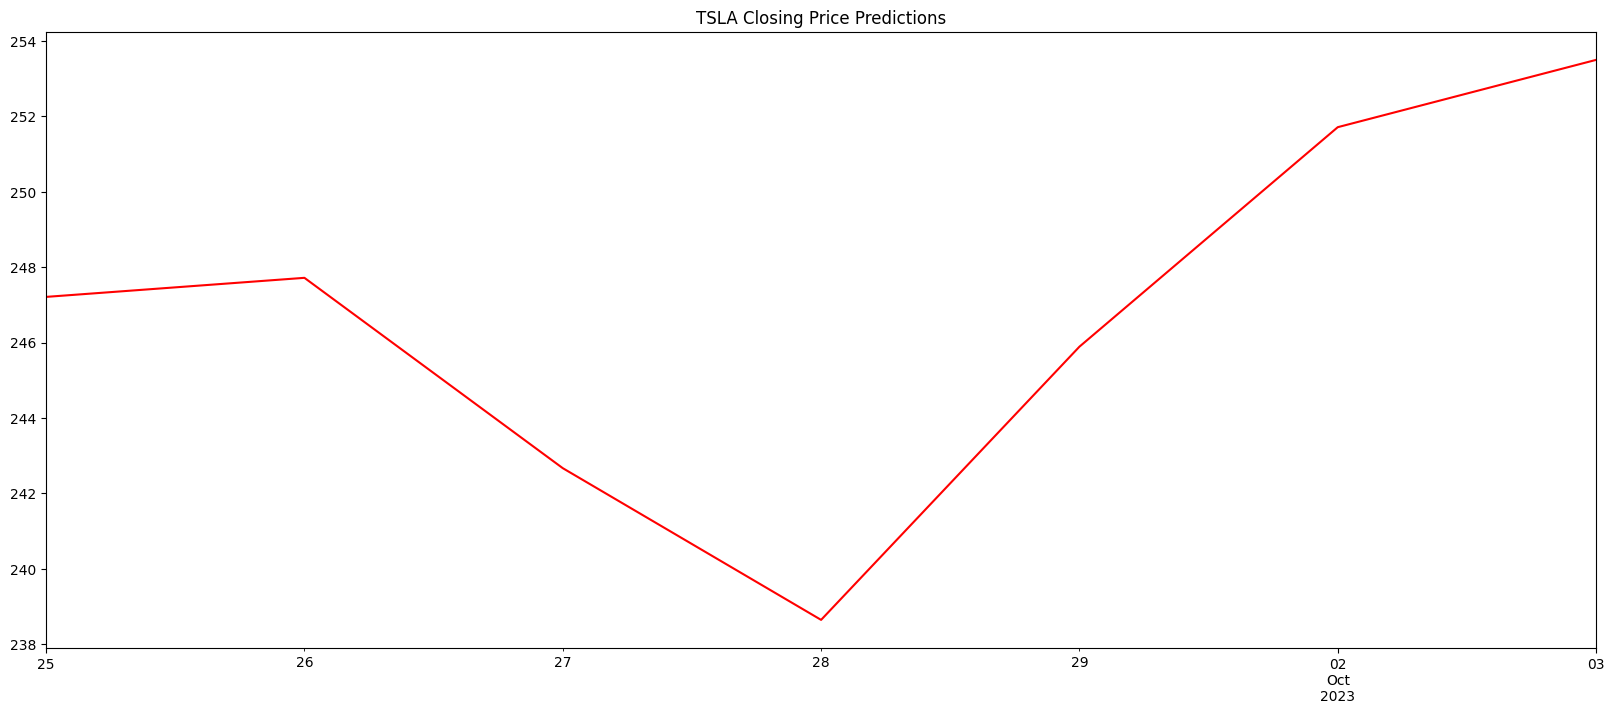

In [21]:
start_date = "2023-09-25"
end_date = "2023-10-03"
df_pred = results.predict(start=start_date, end=end_date)
df_pred[start_date:end_date].plot(figsize=(20,8),color="red")
plt.title("TSLA Closing Price Predictions")
plt.show()


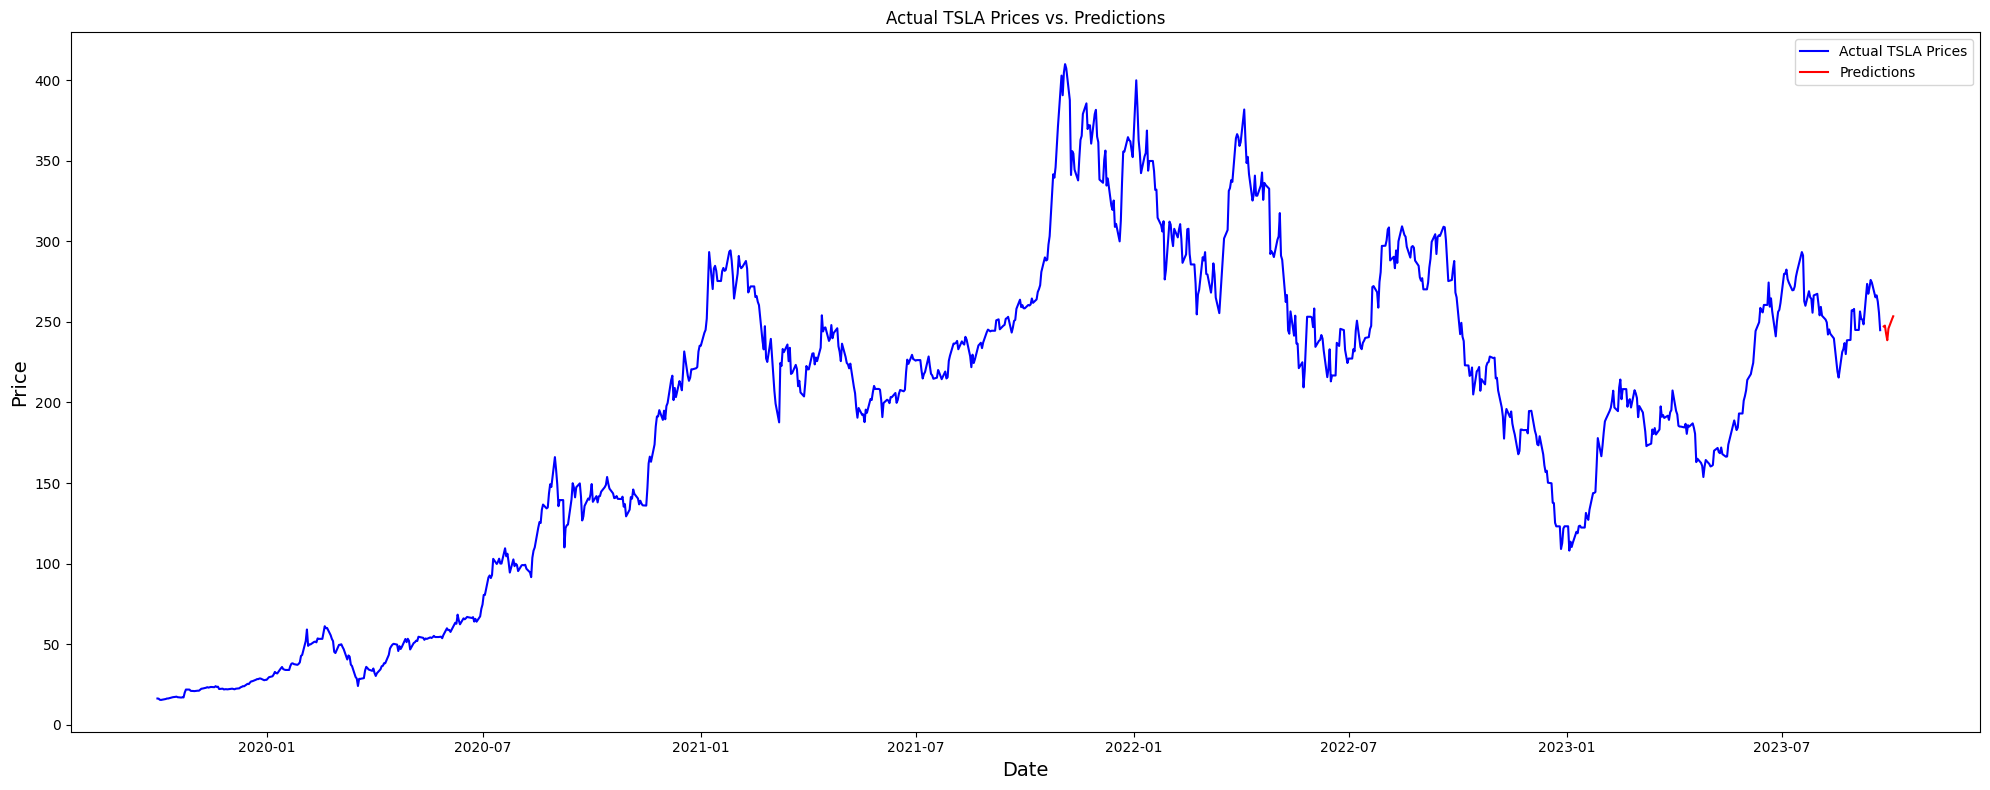

In [22]:

# Select the actual TSLA prices for the desired date range
actual_prices = df['TSLA']['2019-09-24':'2023-09-22']

# Plot both actual prices and predictions
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, label='Actual TSLA Prices', color='blue')
plt.plot(df_pred, label='Predictions', color='red')
plt.title("Actual TSLA Prices vs. Predictions")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Price",fontsize=14)
plt.tight_layout()
plt.legend()
plt.show()


In [23]:
volatility = df['Returns'][1:].std()
print(f"The volatility of Daily returns for TESLA stocks is {volatility*100}%")

The volatility of Daily returns for TESLA stocks is 4.226837062148333%


In [24]:
df.tail()

,TSLA,Returns,lag_1
Date,,,
2023-09-25,246.990005,0.008616,244.880005
2023-09-26,244.119995,-0.011620,246.990005
2023-09-27,240.500000,-0.014829,244.119995
2023-09-28,246.380005,0.024449,240.500000
2023-09-29,250.220001,0.015586,246.380005
